# Agent-Based Model Validation
The five-step validation process for agent-based models as described by Guerini and Moneta (2017). The steps include:
1. Dataset uniformity
2. Analysis of ABM properties
3. VAR estimation and identification
4. Causal structure identification
5. Validation assessment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from scipy import stats, interpolate
from sklearn.decomposition import FastICA
import networkx as nx
from itertools import combinations, permutations
from lingam import VARLiNGAM
from lingam2 import VARLiNGAM_2
# from statsmodels.tsa.stattools import adfuller
    # for the Augmented Dickey-Fuller test to ensure stationarity

ModuleNotFoundError: No module named 'lingam'

## Step 1: Dataset Uniformity
We begin by selecting the variables of interest and preparing the datasets from real-world data (RW-data) and agent-based model simulations (AB-data).

In [ ]:
# Step 1: Dataset uniformity

def uniform_datasets(RW_data, AB_data):
    T_RW = RW_data.shape[0]
    T_AB = AB_data.shape[1]

    # Ensure that the datasets have the same time dimension
    if T_AB > T_RW:
        AB_data = AB_data[:, -T_RW:, :]
    else:
        RW_data = RW_data[-T_AB:, :]
    
    # Variables in the datasets: [C, I, U, Y, P, R]
    # Log transformation for C, I, Y, P
    log_vars = [0, 1, 3, 4]  # indices for C, I, Y, P
    for idx in log_vars:
        RW_data[:, idx] = np.log(RW_data[:, idx])
        AB_data[:, :, idx] = np.log(AB_data[:, :, idx])
    
    # Convert U and R to percentages
    RW_data[:, 2] *= 100  # U
    RW_data[:, 5] *= 100  # R
    AB_data[:, :, 2] *= 100  # U
    AB_data[:, :, 5] *= 100  # R
    
    return RW_data, AB_data

## Step 2: Analysis of ABM Properties
We check for statistical equilibrium and ergodicity of the ABM properties.

In [ ]:
# Step 2: Analysis of ABM properties

# Test for statistical equilibrium across different time periods in the ABM data.
def test_statistical_equilibrium(AB_data):
    M, T, K = AB_data.shape
    p_values = np.zeros((K, T*(T-1)//2))
    
    for k in range(K):
        idx = 0
        for i in range(T):
            for j in range(i+1, T):
                _, p = stats.ks_2samp(AB_data[:, i, k], AB_data[:, j, k])
                p_values[k, idx] = p
                idx += 1
    
    # return the proportion of p-values that are greater than 0.05
    return np.mean(p_values > 0.05, axis=1)

# Test for ergodicity in the ABM data.
def test_ergodicity(AB_data):
    M, T, K = AB_data.shape
    p_values = np.zeros((K, M*T))
    
    for k in range(K):
        idx = 0
        for i in range(M):
            for j in range(T):
                _, p = stats.ks_2samp(AB_data[i, :, k], AB_data[:, j, k])
                p_values[k, idx] = p
                idx += 1

    # return the proportion of p-values that are greater than 0.05
    return np.mean(p_values > 0.05, axis=1)

## Step 3: VAR Estimation and Identification
We estimate the reduced-form VAR model for both RW-data and AB-data.

In [ ]:
def handle_inf_nan(data, method='interpolate'):
    problem_mask = np.isnan(data) | np.isinf(data)
    
    if problem_mask.any():
        problem_rows = np.where(problem_mask.any(axis=1))[0]
        # print(f"Warning: Data contains inf or nan values at rows: {problem_rows}")
        
        if method == 'interpolate':
            for col in range(data.shape[1]):
                mask = problem_mask[:, col]
                if mask.any():
                    good = ~mask
                    f = interpolate.interp1d(np.flatnonzero(good), data[good, col], 
                                             bounds_error=False, fill_value='extrapolate')
                    data[mask, col] = f(np.flatnonzero(mask))
        elif method in ['ffill', 'bfill']:
            data = pd.DataFrame(data).fillna(method=method).values
        elif method == 'mean':
            col_means = np.nanmean(data, axis=0)
            data[problem_mask] = np.take(col_means, np.where(problem_mask)[1])
        else:
            raise ValueError("Invalid method. Choose 'interpolate', 'ffill', 'bfill', or 'mean'.")
        
        print(f"Handled {np.sum(problem_mask)} inf/nan values using {method} method.")
    
    return data

def estimate_var(data, max_lags=10, inf_nan_method='interpolate'):
    data = handle_inf_nan(data, method=inf_nan_method)
    
    try:
        model = VAR(data)
        results = model.fit(maxlags=max_lags, ic='bic')
        return results
    except ValueError as e:
        print(f"Error fitting VAR model: {e}")
        return None

## Step 4: Causal Structure Identification
We identify the causal structure using PC-algorithm and VAR-LiNGAM.

In [ ]:
# Step 4: SVAR identification
def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = np.linalg.lstsq(C[:, idx], C[:, j], rcond=None)[0]
            beta_j = np.linalg.lstsq(C[:, idx], C[:, i], rcond=None)[0]
            res_j = C[:, j] - C[:, idx].dot(beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def pc_algorithm(data, alpha=0.05):
    n, p = data.shape
    G = nx.Graph()
    G.add_nodes_from(range(p))
    G.add_edges_from(combinations(range(p), 2))
    
    #  Test for conditional independence
    def conditional_independence(X, Y, Z):
        if not Z:
            corr, p_value = stats.pearsonr(data[:, X], data[:, Y]) # Pearson correlation
            return p_value > alpha
        else:
            pcorr = partial_corr(data[:, [X, Y] + list(Z)])
            t_stat = pcorr[0, 1] * np.sqrt((n - len(Z) - 2) / (1 - pcorr[0, 1]**2))
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - len(Z) - 2))
            return p_value > alpha
    
    l = 0
    while any(len(list(G.neighbors(node))) >= l for node in G.nodes()):
        for (X, Y) in permutations(G.nodes(), 2):
            if G.has_edge(X, Y):
                Z = list(set(G.neighbors(X)) - {Y})
                if len(Z) >= l:
                    for S in combinations(Z, l):
                        if conditional_independence(X, Y, S):
                            G.remove_edge(X, Y)
                            break
        l += 1
    
    dag = nx.DiGraph()
    dag.add_nodes_from(G.nodes())
    for (X, Y) in G.edges():
        dag.add_edge(X, Y)
    
    return nx.adjacency_matrix(dag).todense()

def var_lingam(residuals):
    ica = FastICA(n_components=residuals.shape[1], random_state=0)
    S = ica.fit_transform(residuals)
    W = ica.mixing_
    
    P = np.zeros_like(W)
    remaining = list(range(W.shape[0]))
    for i in range(W.shape[0]):
        j = remaining[np.argmin([np.sum(np.abs(W[j, remaining])) for j in remaining])]
        P[i, j] = 1
        remaining.remove(j)
    
    W_perm = P.dot(W)
    B = np.eye(W.shape[0]) - np.linalg.inv(W_perm)
    B[np.triu_indices(B.shape[0], 1)] = 0
    
    return B, P

def is_gaussian_multi_test(residuals, significance_level=0.05):
    n_vars = residuals.shape[1]
    
    shapiro_p_values = [stats.shapiro(residuals[:, i])[1] for i in range(n_vars)]
    anderson_results = [stats.anderson(residuals[:, i], 'norm') for i in range(n_vars)]
    
    shapiro_gaussian = sum(p > significance_level for p in shapiro_p_values) > n_vars / 2
    anderson_gaussian = sum(result.statistic < result.critical_values[2] for result in anderson_results) > n_vars / 2
    
    print(f"Shapiro-Wilk test results: {shapiro_gaussian}")
    print(f"Anderson-Darling test results: {anderson_gaussian}")
    
    return shapiro_gaussian and anderson_gaussian

def svar_identification(residuals, var_results):
    is_gaussian = is_gaussian_multi_test(residuals)
    
    if is_gaussian:
        print("Using PC algorithm (Gaussian residuals)")
        B = pc_algorithm(residuals)
    else:
        print("Using VAR-LiNGAM algorithm (non-Gaussian residuals)")
        model = VARLiNGAM_2()
        result = model.fit(residuals)
        B = result.adjacency_matrices_[0]
        # B, _ = var_lingam(residuals)
    
    Gamma0 = np.linalg.inv(np.eye(B.shape[0]) - B)
    Gamma = [Gamma0 @ coef for coef in var_results.coefs]
    
    return Gamma0, Gamma

## Step 5: Validation Assessment
We compare the estimated causal structures using sign, size, and conjugate similarity tests.

In [ ]:
# Step 5: Validation assessment
def compute_similarity(RW_structure, AB_structure):
    sign_similarity = np.mean(np.sign(RW_structure) == np.sign(AB_structure))
    
    size_similarity = np.mean(
        (AB_structure >= RW_structure - 2*np.std(RW_structure)) & 
        (AB_structure <= RW_structure + 2*np.std(RW_structure))
    )
    
    conj_similarity = np.mean(
        (np.sign(RW_structure) == np.sign(AB_structure)) & 
        (AB_structure >= RW_structure - 2*np.std(RW_structure)) & 
        (AB_structure <= RW_structure + 2*np.std(RW_structure))
    )
    
    return sign_similarity, size_similarity, conj_similarity

def analyze_lagged_effects(RW_Gamma, AB_Gammas):
    num_lags = len(RW_Gamma)
    num_vars = RW_Gamma[0].shape[0]
    
    lag_similarities = np.zeros((num_lags, 3))  # For sign, size, and conjunction similarities
    
    for lag in range(num_lags):
        lag_similarities[lag, 0] = np.mean([compute_similarity(RW_Gamma[lag], AB_Gamma[lag])[0] for AB_Gamma in AB_Gammas])
        lag_similarities[lag, 1] = np.mean([compute_similarity(RW_Gamma[lag], AB_Gamma[lag])[1] for AB_Gamma in AB_Gammas])
        lag_similarities[lag, 2] = np.mean([compute_similarity(RW_Gamma[lag], AB_Gamma[lag])[2] for AB_Gamma in AB_Gammas])
    
    return lag_similarities

## Running the Code
We run the five-step validation process on the given ABM and RW-data.

/var/folders/c9/n713l58d4h7cvf9l3l77fx500000gn/T/ipykernel_73931/481683567.py:18: RuntimeWarning: invalid value encountered in log
  AB_data[:, :, idx] = np.log(AB_data[:, :, idx])


Statistical Equilibrium Results:
[0.32869347 0.99286432 0.99241206 0.98512563 0.98899497 0.99125628]

Ergodicity Results:
[0.2125 0.967  0.9565 0.9525 0.9585 0.9665]
AB_data has been written to observe.txt.
Handled 1 inf/nan values using interpolate method.
Shapiro-Wilk test results: False
Anderson-Darling test results: False
Using VAR-LiNGAM algorithm (non-Gaussian residuals)
Shapiro-Wilk test results: False
Anderson-Darling test results: False
Using VAR-LiNGAM algorithm (non-Gaussian residuals)
Shapiro-Wilk test results: False
Anderson-Darling test results: False
Using VAR-LiNGAM algorithm (non-Gaussian residuals)
Shapiro-Wilk test results: False
Anderson-Darling test results: False
Using VAR-LiNGAM algorithm (non-Gaussian residuals)
Shapiro-Wilk test results: False
Anderson-Darling test results: False
Using VAR-LiNGAM algorithm (non-Gaussian residuals)
Shapiro-Wilk test results: False
Anderson-Darling test results: False
Using VAR-LiNGAM algorithm (non-Gaussian residuals)
Shapiro-Wi

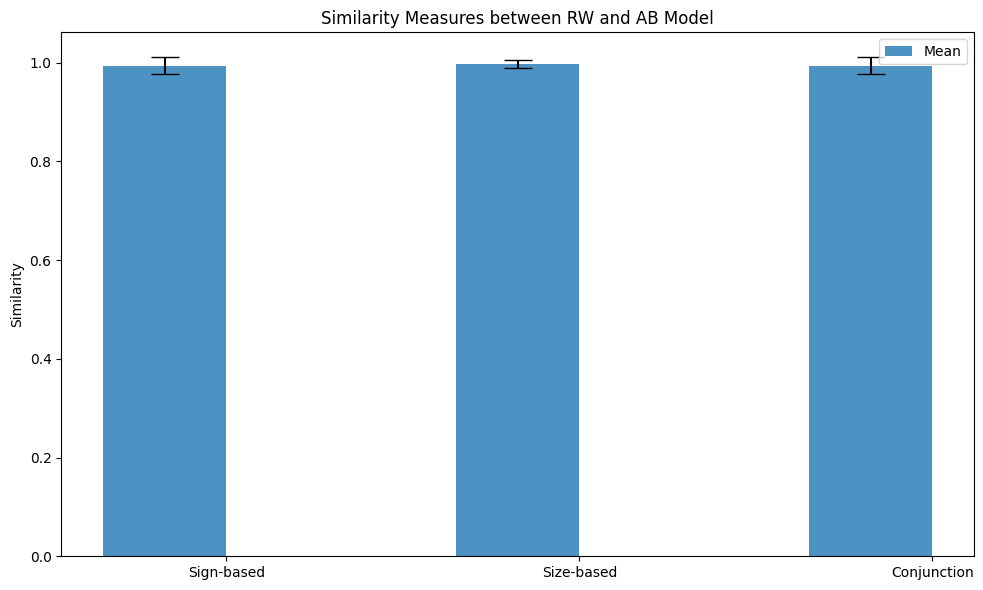

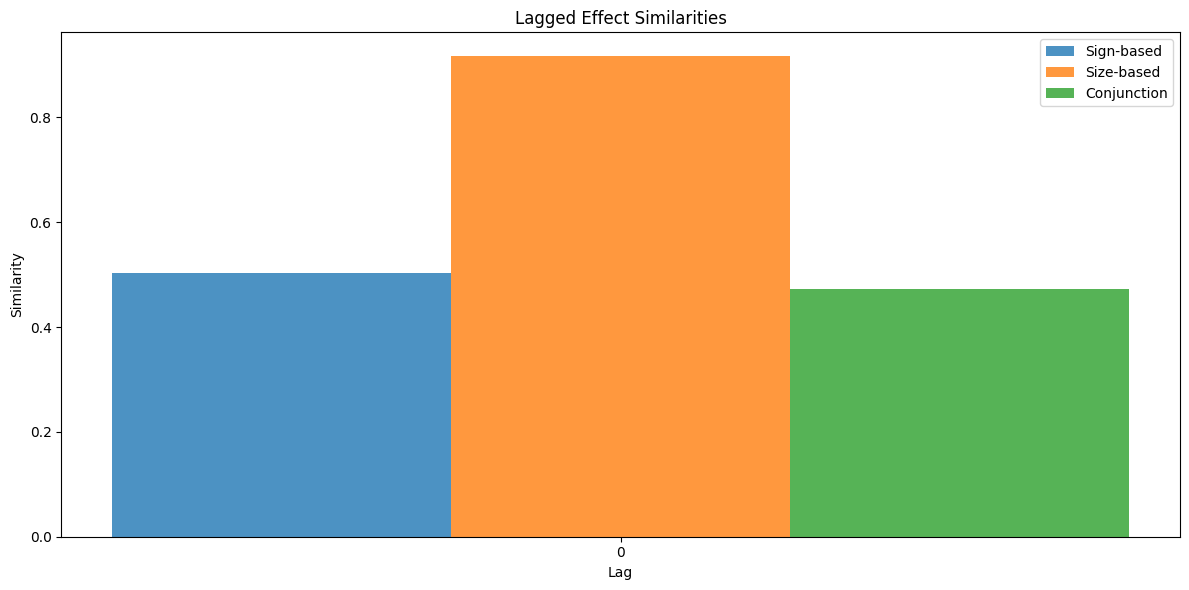

In [ ]:
# Load data
RW_data = pd.read_csv('data/rw_data_non_gaussian.csv').values
AB_data = np.array([pd.read_csv(f'data/abm_data_{i+1}_non_gaussian.csv').values for i in range(10)])

# Step 1: Dataset uniformity
RW_data, AB_data = uniform_datasets(RW_data, AB_data)

# Step 2: Analysis of ABM properties
equilibrium_results = test_statistical_equilibrium(AB_data)
ergodicity_results = test_ergodicity(AB_data)

print("Statistical Equilibrium Results:")
print(equilibrium_results)
print("\nErgodicity Results:")
print(ergodicity_results)

# Step 3: VAR Estimation
RW_var_results = estimate_var(RW_data)
AB_var_results = [estimate_var(AB_data[i]) for i in range(AB_data.shape[0])]

# Step 4: SVAR Identification
RW_Gamma0, RW_Gamma = svar_identification(RW_var_results.resid, RW_var_results)
AB_Gamma0s, AB_Gammas = zip(*[svar_identification(result.resid, result) for result in AB_var_results])

# Convert to numpy arrays for easier manipulation
AB_Gamma0s = np.array(AB_Gamma0s)
AB_Gammas = np.array(AB_Gammas)

# Step 5: Validation Assessment
similarities = []
for i in range(len(AB_Gamma0s)):
    sign_sim, size_sim, conj_sim = compute_similarity(RW_Gamma0, AB_Gamma0s[i])
    similarities.append((sign_sim, size_sim, conj_sim))

similarities = np.array(similarities)

# Compute average similarities across all Monte Carlo simulations
avg_similarities = np.mean(similarities, axis=0)
std_similarities = np.std(similarities, axis=0)

print("\nAverage Similarities (Sign, Size, Conjunction):")
print(avg_similarities)
print("\nStandard Deviation of Similarities:")
print(std_similarities)

# Visualize results
labels = ['Sign-based', 'Size-based', 'Conjunction']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, avg_similarities, width, label='Mean', yerr=std_similarities,
                align='center', alpha=0.8, ecolor='black', capsize=10)

ax.set_ylabel('Similarity')
ax.set_title('Similarity Measures between RW and AB Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

# Analyze lagged effects
lag_similarities = analyze_lagged_effects(RW_Gamma, AB_Gammas)

# Visualize lagged effect similarities
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(lag_similarities))
width = 0.25

ax.bar(x - width, lag_similarities[:, 0], width, label='Sign-based', alpha=0.8)
ax.bar(x, lag_similarities[:, 1], width, label='Size-based', alpha=0.8)
ax.bar(x + width, lag_similarities[:, 2], width, label='Conjunction', alpha=0.8)

ax.set_ylabel('Similarity')
ax.set_xlabel('Lag')
ax.set_title('Lagged Effect Similarities')
ax.set_xticks(x)
ax.legend()

plt.tight_layout()
plt.show()